In [ ]:
!pip install --upgrade xlrd
!pip install --upgrade pandas
!pip install vnstock

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 2.1 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 28 kB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
path = r"/content/drive/MyDrive/Colab Notebooks/Data/data/strongest drop/APH.xlsx"
data = pd.read_excel(path)
stock_data = data.loc[:129]
stock_predict = data.loc[129:]
feed_data = data.loc[129-40:128]

In [ ]:
stock_data_raw = stock_data['Close'].interpolate(method='linear').copy()
data_predict_raw = stock_predict['Close'].interpolate(method='linear').copy()
data_values = stock_data_raw.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_values.reshape(-1,1))

In [ ]:
data_values = data_values.reshape(-1,1)

In [ ]:
length_train = len(scaled_data)-20
window = 40
future_look = 20

In [ ]:
feed_data = scaled_data[len(scaled_data)-window:]
x_feed = []
for i in range(0,int(len(feed_data))):
  x_feed.append(feed_data[i,0])
x_feed = np.array(x_feed)
x_feed = np.reshape(x_feed, (1,x_feed.shape[0],1))

In [ ]:
x_train = []
y_train = []
for i in range(window+future_look, len(scaled_data)):
    x_train.append(scaled_data[i-window-future_look:i-future_look, 0])
    y_train.append(scaled_data[i-future_look:i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1],1))

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(20))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 20)                520       
                                                                 
Total params: 124,245
Trainable params: 124,245
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
70/70 [==============================] - 8s 53ms/step - loss: 0.0319
Epoch 2/3
70/70 [==============================] - 4s 50ms/step - loss: 0.0198
Epoch 3/3
70/70 [==============================] - 3s 45ms/step - loss: 0.0158


In [ ]:
def future_predict(length, predict = model.predict, feed = x_feed):
  y_future = []
  for i in range(0, length, 20):
    y = predict(feed)
    y_future = np.append(y_future,y[0])
    new_feed = np.append(x_feed[0],y[0])
    new_feed = new_feed[20:]
    feed = np.reshape(new_feed, (1, new_feed.shape[0],1))
  return y_future

In [ ]:
future = future_predict(57)

1/1 [==============================] - 0s 56ms/step


In [ ]:
future = np.reshape(future, (future.shape[0],1))
rescaled_future = scaler.inverse_transform(future)

In [ ]:
stock_predict_frame = pd.DataFrame(stock_predict['Close'].to_numpy(),index=stock_predict['Date'], columns = ['Close'])
future_data_frame = pd.DataFrame(rescaled_future, index=stock_predict['Date'], columns = ['Close'])
stock_data_frame = pd.DataFrame(stock_data['Close'].to_numpy(), index=stock_data['Date'], columns = ['Close'])

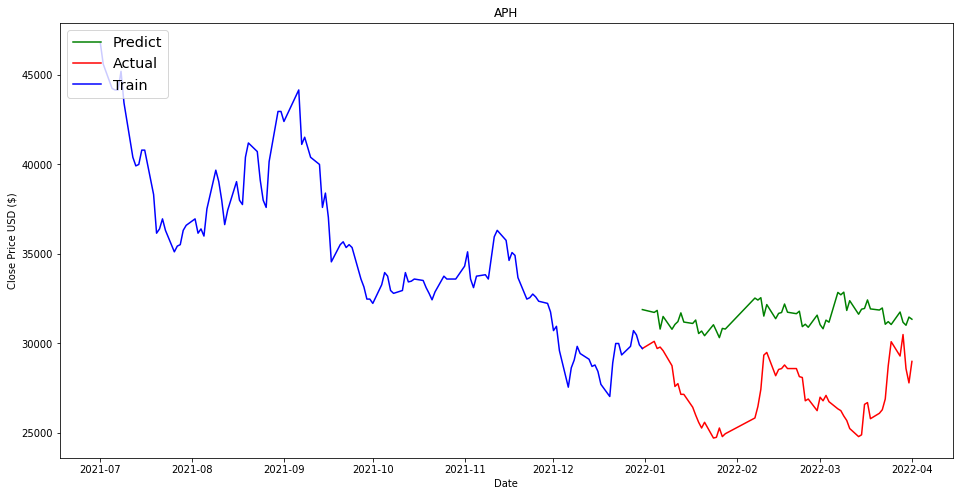

In [ ]:
plt.figure(figsize=(16,8))
plt.title('APH')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(future_data_frame, color='green', label='Predict')
plt.plot(stock_predict_frame, color='red', label='Actual')
plt.plot(stock_data_frame, color='blue', label = 'Train')
plt.legend(loc='upper left', shadow=False, fontsize='x-large')

In [ ]:
mae = mean_absolute_error(stock_predict_frame['Close'].to_numpy(),future_data_frame['Close'].to_numpy())

In [ ]:
print(mae)

4236.297441263997
